# BENVENUTI NEL MONDO FATATO DELLA LUDOPATIA!

## Oggi andremo a vedere come applicare il machine learning e la distribuzione di Poisson per scommettere al meglio sugli europei!

In [3]:
# Importazione delle librerie
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [4]:
# Carichiamo i dataset
fifa_ranking = pd.read_csv('data/raw/fifa_ranking-2024-04-04.csv')
goalscorers = pd.read_csv('data/raw/goalscorers.csv')
results = pd.read_csv('data/raw/results.csv')
shootouts = pd.read_csv('data/raw/shootouts.csv')

# Andiamo a mostrare le prime righe per ogni dataset per capirne meglio la struttura
fifa_ranking_head = fifa_ranking.head()
goalscorers_head = goalscorers.head()
results_head = results.head()
shootouts_head = shootouts.head()

fifa_ranking_head, goalscorers_head, results_head, shootouts_head

(   rank country_full country_abrv  total_points  previous_points  rank_change  \
 0  83.0    Guatemala          GUA          15.0              0.0           83   
 1  32.0       Zambia          ZAM          38.0              0.0           32   
 2  33.0     Portugal          POR          38.0              0.0           33   
 3  34.0      Austria          AUT          38.0              0.0           34   
 4  35.0     Colombia          COL          36.0              0.0           35   
 
   confederation   rank_date  
 0      CONCACAF  1992-12-31  
 1           CAF  1992-12-31  
 2          UEFA  1992-12-31  
 3          UEFA  1992-12-31  
 4      CONMEBOL  1992-12-31  ,
          date  home_team away_team       team            scorer  minute  \
 0  1916-07-02      Chile   Uruguay    Uruguay   José Piendibene    44.0   
 1  1916-07-02      Chile   Uruguay    Uruguay  Isabelino Gradín    55.0   
 2  1916-07-02      Chile   Uruguay    Uruguay  Isabelino Gradín    70.0   
 3  1916-07-02 

In [5]:
# Mostriamo i data types
fifa_ranking.dtypes, goalscorers.dtypes, results.dtypes, shootouts.dtypes

(rank               float64
 country_full        object
 country_abrv        object
 total_points       float64
 previous_points    float64
 rank_change          int64
 confederation       object
 rank_date           object
 dtype: object,
 date          object
 home_team     object
 away_team     object
 team          object
 scorer        object
 minute       float64
 own_goal        bool
 penalty         bool
 dtype: object,
 date           object
 home_team      object
 away_team      object
 home_score    float64
 away_score    float64
 tournament     object
 city           object
 country        object
 neutral          bool
 dtype: object,
 date             object
 home_team        object
 away_team        object
 winner           object
 first_shooter    object
 dtype: object)

In [6]:
# Converti le colonne di data in formato datetime per coerenza fifa_ranking['rank_date'] = pd.to_datetime(fifa_ranking['rank_date'])
fifa_ranking['rank_date'] = pd.to_datetime(fifa_ranking['rank_date'])
goalscorers['date'] = pd.to_datetime(goalscorers['date'])
results['date'] = pd.to_datetime(results['date'])
shootouts['date'] = pd.to_datetime(shootouts['date'])

# Mostriamo i data types
fifa_ranking.dtypes, goalscorers.dtypes, results.dtypes, shootouts.dtypes

(rank                      float64
 country_full               object
 country_abrv               object
 total_points              float64
 previous_points           float64
 rank_change                 int64
 confederation              object
 rank_date          datetime64[ns]
 dtype: object,
 date         datetime64[ns]
 home_team            object
 away_team            object
 team                 object
 scorer               object
 minute              float64
 own_goal               bool
 penalty                bool
 dtype: object,
 date          datetime64[ns]
 home_team             object
 away_team             object
 home_score           float64
 away_score           float64
 tournament            object
 city                  object
 country               object
 neutral                 bool
 dtype: object,
 date             datetime64[ns]
 home_team                object
 away_team                object
 winner                   object
 first_shooter            object
 dtyp

In [7]:
# Unisci i risultati delle partite con i marcatori
merged_results_goalscorers = pd.merge(results, goalscorers, on=['date', 'home_team', 'away_team'], how='left')

# Unisci il dataframe risultante con i dati dei calci di rigore
merged_results_goalscorers_shootouts = pd.merge(merged_results_goalscorers, shootouts, on=['date', 'home_team', 'away_team'], how='left')

# Rimuovi le colonne non desiderate
columns_to_remove = ['team', 'scorer', 'minute', 'own_goal', 'penalty', 'winner', 'first_shooter']
merged_results_goalscorers_shootouts = merged_results_goalscorers_shootouts.drop(columns_to_remove, axis=1)

merged_results_goalscorers_shootouts.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [8]:
# Aggiungere le colonne di squadra per la classifica
merged_results_goalscorers_shootouts['home_team_ranking'] = merged_results_goalscorers_shootouts['home_team']
merged_results_goalscorers_shootouts['away_team_ranking'] = merged_results_goalscorers_shootouts['away_team']

# Unire la classifica della squadra di casa
home_ranking = fifa_ranking.rename(columns={
    'country_full': 'home_team_ranking',     # Rinominare 'country_full' in 'home_team_ranking'
    'rank': 'home_rank',                     # Rinominare 'rank' in 'home_rank'
    'total_points': 'home_total_points',     # Rinominare 'total_points' in 'home_total_points'
    'previous_points': 'home_previous_points', # Rinominare 'previous_points' in 'home_previous_points'
    'rank_change': 'home_rank_change',       # Rinominare 'rank_change' in 'home_rank_change'
    'confederation': 'home_confederation',   # Rinominare 'confederation' in 'home_confederation'
    'rank_date': 'home_rank_date'            # Rinominare 'rank_date' in 'home_rank_date'
})

# Merge "as of" per unire i dati di ranking della squadra di casa
merged_with_home_ranking = pd.merge_asof(
    merged_results_goalscorers_shootouts.sort_values('date'),  # Ordinare per data
    home_ranking.sort_values('home_rank_date'),                # Ordinare per data di ranking
    left_on='date',                                            # Unire sulla colonna 'date'
    right_on='home_rank_date',                                 # Unire sulla colonna 'home_rank_date'
    by='home_team_ranking',                                    # Unire sulla colonna 'home_team_ranking'
    direction='backward'                                       # Prendere la data piu' vicina ma non successiva
)

# Unire la classifica della squadra in trasferta
away_ranking = fifa_ranking.rename(columns={
    'country_full': 'away_team_ranking',     # Rinominare 'country_full' in 'away_team_ranking'
    'rank': 'away_rank',                     # Rinominare 'rank' in 'away_rank'
    'total_points': 'away_total_points',     # Rinominare 'total_points' in 'away_total_points'
    'previous_points': 'away_previous_points', # Rinominare 'previous_points' in 'away_previous_points'
    'rank_change': 'away_rank_change',       # Rinominare 'rank_change' in 'away_rank_change'
    'confederation': 'away_confederation',   # Rinominare 'confederation' in 'away_confederation'
    'rank_date': 'away_rank_date'            # Rinominare 'rank_date' in 'away_rank_date'
})

# Merge "as of" per unire i dati di ranking della squadra in trasferta
merged_with_away_ranking = pd.merge_asof(
    merged_with_home_ranking.sort_values('date'),  # Ordinare per data
    away_ranking.sort_values('away_rank_date'),    # Ordinare per data di ranking
    left_on='date',                                # Unire sulla colonna 'date'
    right_on='away_rank_date',                     # Unire sulla colonna 'away_rank_date'
    by='away_team_ranking',                        # Unire sulla colonna 'away_team_ranking'
    direction='backward'                           # Prendere la data piu' vicina ma non successiva
)

# Riempire i valori mancanti con NaN
merged_with_away_ranking = merged_with_away_ranking.fillna(np.nan)

# Calcolare la media dei gol segnati e subiti per ogni squadra
home_goals_avg = merged_with_away_ranking.groupby('home_team')['home_score'].mean()
away_goals_avg = merged_with_away_ranking.groupby('away_team')['away_score'].mean()
home_goals_conceded_avg = merged_with_away_ranking.groupby('home_team')['away_score'].mean()
away_goals_conceded_avg = merged_with_away_ranking.groupby('away_team')['home_score'].mean()

# Funzione per aggiungere le caratteristiche al dataframe
def add_features(db_finale_europeo_clear):
    db_finale_europeo_clear['home_goals_avg'] = db_finale_europeo_clear['home_team'].map(home_goals_avg)
    db_finale_europeo_clear['away_goals_avg'] = db_finale_europeo_clear['away_team'].map(away_goals_avg)
    db_finale_europeo_clear['home_goals_conceded_avg'] = db_finale_europeo_clear['home_team'].map(home_goals_conceded_avg)
    db_finale_europeo_clear['away_goals_conceded_avg'] = db_finale_europeo_clear['away_team'].map(away_goals_conceded_avg)
    db_finale_europeo_clear['rank_diff'] = db_finale_europeo_clear['home_rank'] - db_finale_europeo_clear['away_rank']
    return db_finale_europeo_clear

# Aggiungere le nuove caratteristiche al dataframe
merged_with_away_ranking = add_features(merged_with_away_ranking)

# Rimuovo le colonne inutili
columns_to_remove = ['country_abrv_x', 'country_abrv_y', 'home_rank_date', 'away_rank_date', 'home_confederation', 'away_confederation', 'city']
merged_with_away_ranking = merged_with_away_ranking.drop(columns=columns_to_remove, axis=1)

# Mostra le prime righe del dataframe con le nuove caratteristiche
merged_with_away_ranking.head(40)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_team_ranking,away_team_ranking,...,home_rank_change,away_rank,away_total_points,away_previous_points,away_rank_change,home_goals_avg,away_goals_avg,home_goals_conceded_avg,away_goals_conceded_avg,rank_diff
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Scotland,False,Scotland,England,...,NaN,NaN,NaN,NaN,NaN,2.261696,2.611435,1.187135,1.100350,NaN
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,England,False,England,Scotland,...,NaN,NaN,NaN,NaN,NaN,2.921225,1.684211,0.907002,1.695906,NaN
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Scotland,False,Scotland,England,...,NaN,NaN,NaN,NaN,NaN,2.261696,2.611435,1.187135,1.100350,NaN
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,England,False,England,Scotland,...,NaN,NaN,NaN,NaN,NaN,2.921225,1.684211,0.907002,1.695906,NaN
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Scotland,False,Scotland,England,...,NaN,NaN,NaN,NaN,NaN,2.261696,2.611435,1.187135,1.100350,NaN
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Scotland,False,Scotland,Wales,...,NaN,NaN,NaN,NaN,NaN,2.261696,1.302721,1.187135,2.195578,NaN
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,England,False,England,Scotland,...,NaN,NaN,NaN,NaN,NaN,2.921225,1.684211,0.907002,1.695906,NaN
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wales,False,Wales,Scotland,...,NaN,NaN,NaN,NaN,NaN,1.800000,1.684211,1.440000,1.695906,NaN
8,1878-03-02,Scotland,England,7.0,2.0,Friendly,Scotland,False,Scotland,England,...,NaN,NaN,NaN,NaN,NaN,2.261696,2.611435,1.187135,1.100350,NaN
9,1878-03-23,Scotland,Wales,9.0,0.0,Friendly,Scotland,False,Scotland,Wales,...,NaN,NaN,NaN,NaN,NaN,2.261696,1.302721,1.187135,2.195578,NaN


In [9]:
# Rimuovi le colonne non desiderate
columns_to_remove2 = ['home_team_ranking', 'away_team_ranking']
merged_with_away_ranking = merged_with_away_ranking.drop(columns_to_remove2, axis=1)

# Rinomino il dataset 
db_finale = merged_with_away_ranking

db_finale.to_csv("data/processed/db_finale.csv", index=False)

In [10]:
db_finale = pd.read_csv("data/processed/db_finale.csv")


In [11]:
db_finale.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'home_rank', 'home_total_points',
       'home_previous_points', 'home_rank_change', 'away_rank',
       'away_total_points', 'away_previous_points', 'away_rank_change',
       'home_goals_avg', 'away_goals_avg', 'home_goals_conceded_avg',
       'away_goals_conceded_avg', 'rank_diff'],
      dtype='object')

In [12]:
# Converto le colonne in float values
# Lista delle colonne da escludere dalla conversione
escludi_cols = ['date']

# Seleziono le colonne da convertire escludendo quelle specificate
cols_to_convert = db_finale.columns.difference(escludi_cols)

# Converto le colonne selezionate in valori float
db_finale[cols_to_convert] = db_finale[cols_to_convert].apply(pd.to_numeric, errors='coerce')


db_finale.dtypes

date                        object
home_team                  float64
away_team                  float64
home_score                 float64
away_score                 float64
tournament                 float64
country                    float64
neutral                       bool
home_rank                  float64
home_total_points          float64
home_previous_points       float64
home_rank_change           float64
away_rank                  float64
away_total_points          float64
away_previous_points       float64
away_rank_change           float64
home_goals_avg             float64
away_goals_avg             float64
home_goals_conceded_avg    float64
away_goals_conceded_avg    float64
rank_diff                  float64
dtype: object

Adesso dobbiamo capire quanti anni sono da prendere in considerazione

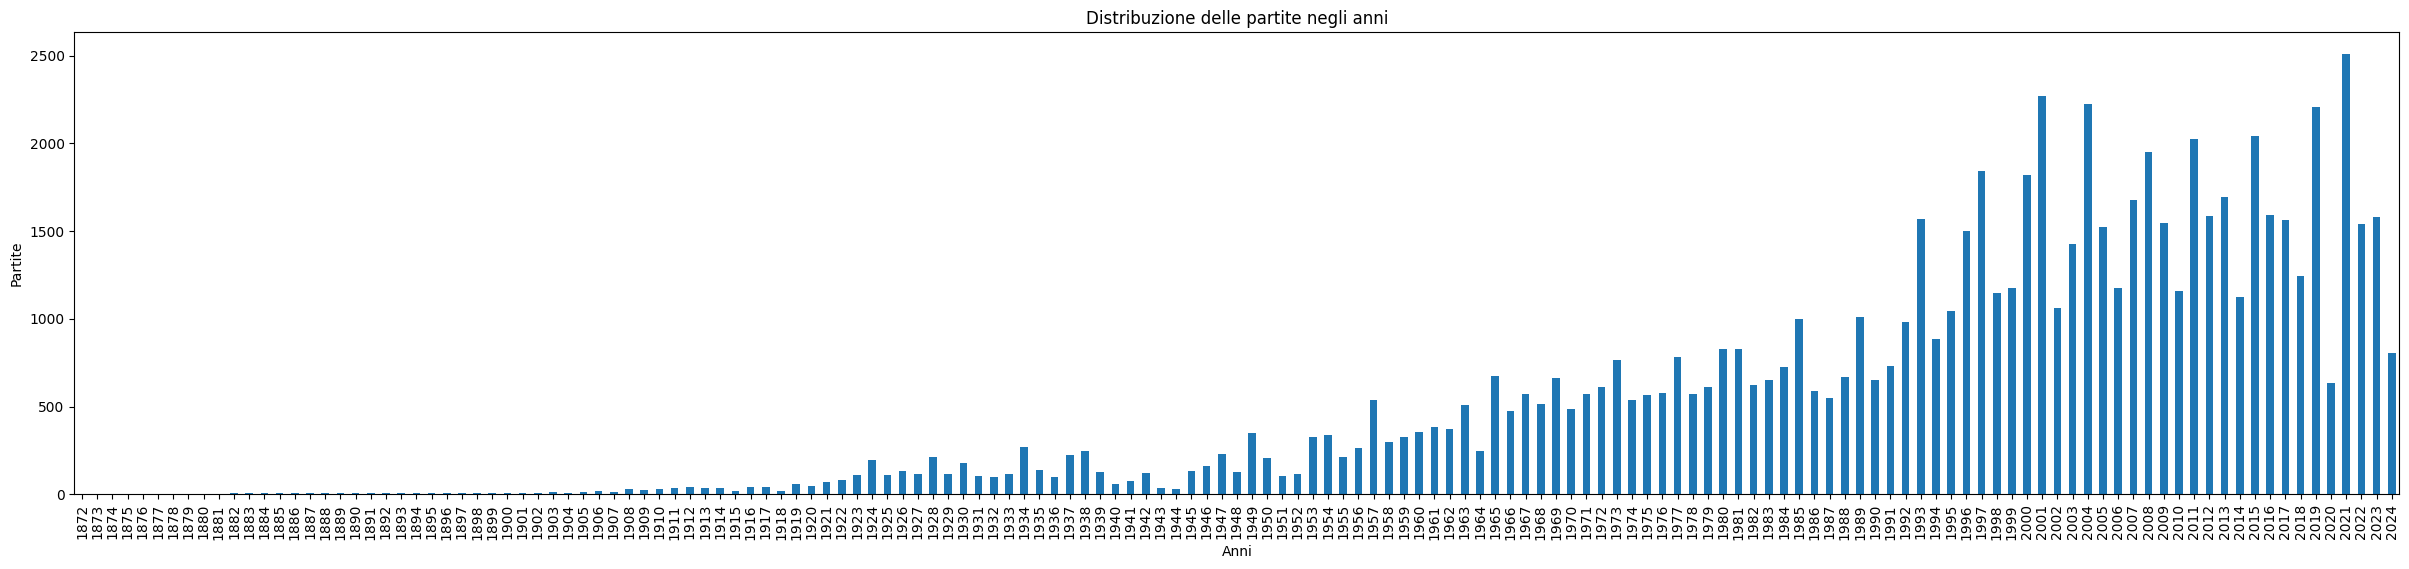

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Carico il dataset
db_finale = pd.read_csv("data/processed/db_finale.csv")

# Converto la colonna 'date' in datetime
db_finale['date'] = pd.to_datetime(db_finale['date'])

# Distribuzione delle partite per anno --> rimuovere date o year (prob date ma nossicuro)
db_finale['year'] = db_finale['date'].dt.year
year_counts = db_finale['year'].value_counts().sort_index()

# Plot della distribuzione
plt.figure(figsize=(30, 6))
year_counts.plot(kind='bar')
plt.xlabel('Anni')
plt.ylabel('Partite')
plt.title('Distribuzione delle partite negli anni')
plt.show()

In [14]:
# Filtro i dati per includere solo gli ultimi 5 anni
recent_years = 5
cutoff_date = pd.Timestamp.now() - pd.DateOffset(years=recent_years)
db_finale_recent = db_finale[db_finale['date'] >= cutoff_date]

# Verifico le date comprese nel dataset recente
print(db_finale_recent['date'].min(), db_finale_recent['date'].max())
print(db_finale_recent.shape)

# Resetta l'indice del DataFrame filtrato
db_finale_recent = db_finale_recent.reset_index(drop=True)

# Salvo il nuovo dataset filtrato
db_finale_recent.to_csv("data/processed/db_finale_recent.csv", index=False)

2019-07-05 00:00:00 2024-07-14 00:00:00
(8316, 22)


In [15]:
db_finale_recent.head()

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_rank,home_total_points,...,away_rank,away_total_points,away_previous_points,away_rank_change,home_goals_avg,away_goals_avg,home_goals_conceded_avg,away_goals_conceded_avg,rank_diff,year
0,2019-07-05,Morocco,Benin,1.0,1.0,African Cup of Nations,Egypt,True,47.0,1429.0,...,88.0,1273.0,1267.0,-3.0,2.102174,0.861607,0.663043,2.468750,-41.0,2019
1,2019-07-05,Morocco,Benin,1.0,1.0,African Cup of Nations,Egypt,True,47.0,1429.0,...,88.0,1273.0,1267.0,-3.0,2.102174,0.861607,0.663043,2.468750,-41.0,2019
2,2019-07-05,Uganda,Senegal,0.0,1.0,African Cup of Nations,Egypt,True,80.0,1299.0,...,22.0,1515.0,1515.0,-1.0,1.984568,1.367742,0.959877,1.290323,58.0,2019
3,2019-07-06,Nigeria,Cameroon,3.0,2.0,African Cup of Nations,Egypt,True,45.0,1433.0,...,51.0,1404.0,1399.0,-3.0,2.200000,1.373602,0.950000,1.554810,-6.0,2019
4,2019-07-06,Egypt,South Africa,0.0,1.0,African Cup of Nations,Egypt,False,58.0,1384.0,...,72.0,1335.0,1335.0,-1.0,2.571637,1.338403,1.039474,1.547529,-14.0,2019


In [16]:
if 'home_win' not in db_finale_recent.columns:
    db_finale_recent['home_win'] = (db_finale_recent['home_score'] > db_finale_recent['away_score']).astype(int)
if 'away_win' not in db_finale_recent.columns:
    db_finale_recent['away_win'] = (db_finale_recent['home_score'] < db_finale_recent['away_score']).astype(int)
if 'draw' not in db_finale_recent.columns:
    db_finale_recent['draw'] = (db_finale_recent['home_score'] == db_finale_recent['away_score']).astype(int)

db_finale_recent.head()

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_rank,home_total_points,...,away_rank_change,home_goals_avg,away_goals_avg,home_goals_conceded_avg,away_goals_conceded_avg,rank_diff,year,home_win,away_win,draw
0,2019-07-05,Morocco,Benin,1.0,1.0,African Cup of Nations,Egypt,True,47.0,1429.0,...,-3.0,2.102174,0.861607,0.663043,2.468750,-41.0,2019,0,0,1
1,2019-07-05,Morocco,Benin,1.0,1.0,African Cup of Nations,Egypt,True,47.0,1429.0,...,-3.0,2.102174,0.861607,0.663043,2.468750,-41.0,2019,0,0,1
2,2019-07-05,Uganda,Senegal,0.0,1.0,African Cup of Nations,Egypt,True,80.0,1299.0,...,-1.0,1.984568,1.367742,0.959877,1.290323,58.0,2019,0,1,0
3,2019-07-06,Nigeria,Cameroon,3.0,2.0,African Cup of Nations,Egypt,True,45.0,1433.0,...,-3.0,2.200000,1.373602,0.950000,1.554810,-6.0,2019,1,0,0
4,2019-07-06,Egypt,South Africa,0.0,1.0,African Cup of Nations,Egypt,False,58.0,1384.0,...,-1.0,2.571637,1.338403,1.039474,1.547529,-14.0,2019,0,1,0


In [17]:
# Define the list of European teams and relevant tournaments
european_teams = [
    'Germany', 'Belgium', 'France', 'Portugal', 'Scotland', 'Spain', 'Turkey',
    'Austria', 'England', 'Hungary', 'Slovakia', 'Denmark', 'Netherlands',
    'Romania', 'Switzerland', 'Serbia', 'Czech Republic', 'Italy', 'Slovenia',
    'Croatia', 'Georgia', 'Ukraine', 'Poland'
]

relevant_tournaments = ['UEFA Euro', 'UEFA Euro qualification', 'Friendly', 
                        'Fifa World Cup', 'World Cup qualification', 
                        'UEFA Nations League', 'FIFA World Cup qualification']

# Filter the dataframe for matches involving European teams and relevant tournaments
db_finale_europeo = db_finale_recent[
    (db_finale_recent['tournament'].isin(relevant_tournaments)) &
    ((db_finale_recent['home_team'].isin(european_teams)) | (db_finale_recent['away_team'].isin(european_teams))) 
]

# Salvataggio del dataset filtrato
db_finale_europeo.to_csv("data/processed/db_finale_europeo.csv", index=False)

# Verifica il dataset filtrato
print(db_finale_europeo.head())
print(db_finale_europeo.info())


          date            home_team    away_team  home_score  away_score  \
131 2019-09-05            Gibraltar      Denmark         0.0         6.0   
132 2019-09-05  Republic of Ireland  Switzerland         1.0         1.0   
133 2019-09-05  Republic of Ireland  Switzerland         1.0         1.0   
135 2019-09-05          South Korea      Georgia         2.0         2.0   
137 2019-09-05           Montenegro      Hungary         2.0         1.0   

                  tournament              country  neutral  home_rank  \
131  UEFA Euro qualification            Gibraltar    False      198.0   
132  UEFA Euro qualification  Republic of Ireland    False       32.0   
133  UEFA Euro qualification  Republic of Ireland    False       32.0   
135                 Friendly               Turkey     True        NaN   
137                 Friendly           Montenegro    False       55.0   

     home_total_points  ...  away_rank_change  home_goals_avg  away_goals_avg  \
131              893.0 

In [18]:
db_finale_europeo_clear = db_finale_europeo.dropna()

db_finale_europeo_clear.to_csv("data/processed/db_finale_europeo_clear.csv", index=False)


In [19]:
db_finale_europeo_clear

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_rank,home_total_points,...,away_rank_change,home_goals_avg,away_goals_avg,home_goals_conceded_avg,away_goals_conceded_avg,rank_diff,year,home_win,away_win,draw
131,2019-09-05,Gibraltar,Denmark,0.0,6.0,UEFA Euro qualification,Gibraltar,False,198.0,893.00,...,3.0,0.828571,1.742156,3.657143,1.770805,185.0,2019,0,1,0
132,2019-09-05,Republic of Ireland,Switzerland,1.0,1.0,UEFA Euro qualification,Republic of Ireland,False,32.0,1489.00,...,2.0,2.023529,1.531292,1.277311,2.033289,21.0,2019,0,0,1
133,2019-09-05,Republic of Ireland,Switzerland,1.0,1.0,UEFA Euro qualification,Republic of Ireland,False,32.0,1489.00,...,2.0,2.023529,1.531292,1.277311,2.033289,21.0,2019,0,0,1
137,2019-09-05,Montenegro,Hungary,2.0,1.0,Friendly,Montenegro,False,55.0,1401.00,...,3.0,1.670968,1.957396,1.522581,1.975148,10.0,2019,1,0,0
141,2019-09-05,Gibraltar,Denmark,0.0,6.0,UEFA Euro qualification,Gibraltar,False,198.0,893.00,...,3.0,0.828571,1.742156,3.657143,1.770805,185.0,2019,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8226,2024-06-16,Slovenia,Denmark,1.0,1.0,UEFA Euro,Germany,True,57.0,1427.84,...,0.0,1.855670,1.742156,1.274914,1.770805,36.0,2024,0,0,1
8227,2024-06-16,Serbia,England,0.0,1.0,UEFA Euro,Germany,True,33.0,1514.20,...,1.0,2.614618,2.611435,1.235880,1.100350,29.0,2024,0,1,0
8228,2024-06-16,Poland,Netherlands,1.0,2.0,UEFA Euro,Germany,True,28.0,1531.49,...,1.0,2.604138,2.259811,1.107586,1.442490,21.0,2024,0,1,0
8229,2024-06-16,Poland,Netherlands,1.0,2.0,UEFA Euro,Germany,True,28.0,1531.49,...,1.0,2.604138,2.259811,1.107586,1.442490,21.0,2024,0,1,0


In [20]:
# Calcolare il numero totale di righe nel db
total_rows = len(db_finale_europeo_clear)

# Iterare su ogni colonna per calcolare e stampare la percentuale di valori nulli
for col in db_finale_europeo_clear.columns:
    null_count = db_finale_europeo_clear[col].isna().sum()
    null_percentage = (null_count / total_rows) * 100
    print(f"{col}: Valori nulli: {null_count}, Percentuale nulli: {null_percentage:.2f}%")


date: Valori nulli: 0, Percentuale nulli: 0.00%
home_team: Valori nulli: 0, Percentuale nulli: 0.00%
away_team: Valori nulli: 0, Percentuale nulli: 0.00%
home_score: Valori nulli: 0, Percentuale nulli: 0.00%
away_score: Valori nulli: 0, Percentuale nulli: 0.00%
tournament: Valori nulli: 0, Percentuale nulli: 0.00%
country: Valori nulli: 0, Percentuale nulli: 0.00%
neutral: Valori nulli: 0, Percentuale nulli: 0.00%
home_rank: Valori nulli: 0, Percentuale nulli: 0.00%
home_total_points: Valori nulli: 0, Percentuale nulli: 0.00%
home_previous_points: Valori nulli: 0, Percentuale nulli: 0.00%
home_rank_change: Valori nulli: 0, Percentuale nulli: 0.00%
away_rank: Valori nulli: 0, Percentuale nulli: 0.00%
away_total_points: Valori nulli: 0, Percentuale nulli: 0.00%
away_previous_points: Valori nulli: 0, Percentuale nulli: 0.00%
away_rank_change: Valori nulli: 0, Percentuale nulli: 0.00%
home_goals_avg: Valori nulli: 0, Percentuale nulli: 0.00%
away_goals_avg: Valori nulli: 0, Percentuale nul

Il nostro database non presenta valori nulli, direi ottimo! 

# Modello di Machine learning

Initial Random Forest Cross-Validation:


C:\Users\AndreaTedesco\AppData\Local\Temp\ipykernel_19332\2457656248.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_finale_europeo_clear.loc[:, 'result'] = db_finale_europeo_clear.apply(combine_labels, axis=1)


Cross-Validation Scores: [0.85949178 0.73243647 0.85329341 0.76646707 0.87125749]
Average Cross-Validation Score: 0.8165892430385864
Best parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Random Forest Classification Report
              precision    recall  f1-score   support

    home_win       0.97      0.95      0.96       238
    away_win       0.95      0.94      0.95       220
        draw       0.92      0.95      0.94       211

    accuracy                           0.95       669
   macro avg       0.95      0.95      0.95       669
weighted avg       0.95      0.95      0.95       669

Random Forest Accuracy: 0.9461883408071748
Random Forest Cross-Validation after Tuning:
Cross-Validation Scores: [0.85650224 0.73692078 0.85628743 0.76347305 0.86676647]
Average Cross-Validation Score: 0.8159899931079544


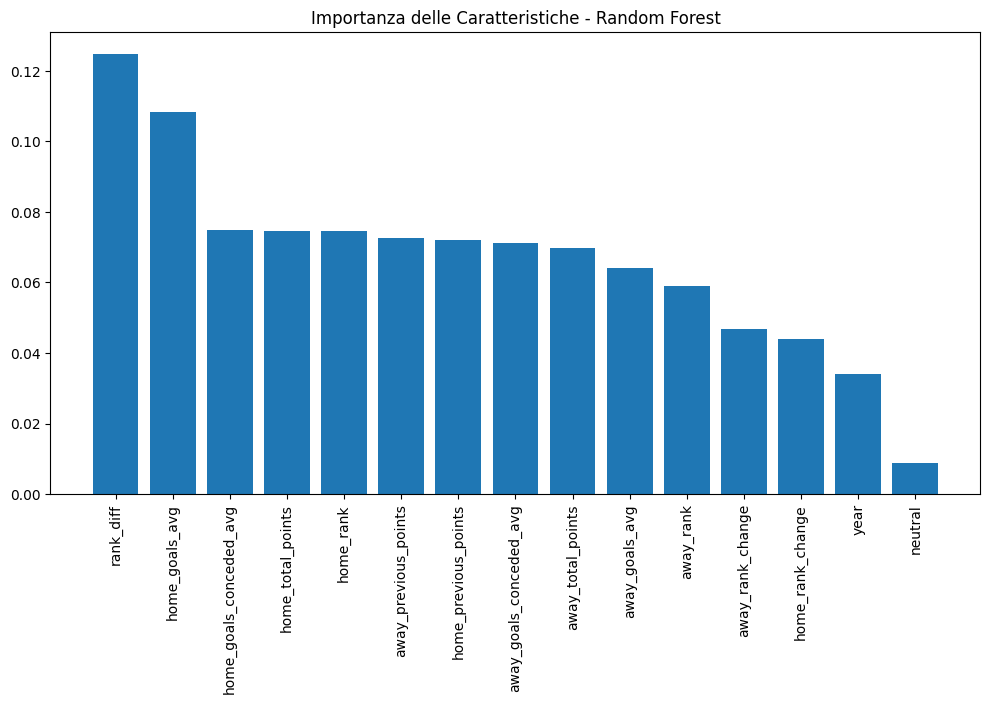

In [21]:
# Importazione delle librerie
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt



# Preparazione dei dati
features = db_finale_europeo_clear[[
       'neutral', 'home_rank', 'home_total_points',
       'home_previous_points', 'home_rank_change', 'away_rank',
       'away_total_points', 'away_previous_points', 'away_rank_change',
       'home_goals_avg', 'away_goals_avg', 'home_goals_conceded_avg',
       'away_goals_conceded_avg', 'rank_diff', 'year']]

# Combinare le etichette in una singola colonna
def combine_labels(row):
    if row['home_win'] == 1:
        return 0
    elif row['away_win'] == 1:
        return 1
    else:
        return 2

db_finale_europeo_clear.loc[:, 'result'] = db_finale_europeo_clear.apply(combine_labels, axis=1)
label = db_finale_europeo_clear['result']

# Bilanciamento delle classi con SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(features, label)

# Suddivisione del dataset bilanciato
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Funzione per trovare i migliori iperparametri per Random Forest
def tune_rf(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300], # numero massimo di alberi --> prendo 3 possibili valori
        'max_features': ['sqrt', 'log2'], # numero di features da considerare per ogni split --> o radice quadrata o logaritmo base 2 
        'max_depth': [10, 20, 30, 40, None], # profondità massima di ogni albero --> prendo 5 possibili valori --> None indica nessun limite
        'criterion': ['gini', 'entropy'] # criterio che indica la qualità della divisione --> prendo 2 possibili vie  --> impurità di Gini o entropia
    }

    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring='accuracy', cv=3)
    grid_search.fit(X_train, y_train)

    print(f'Best parameters: {grid_search.best_params_}')
    return grid_search.best_estimator_

# Funzione per valutare il modello con la cross-validation
def cross_validate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'Cross-Validation Scores: {scores}')
    print(f'Average Cross-Validation Score: {scores.mean()}')

# Valutazione iniziale del modello Random Forest con cross-validation
initial_rf_model = RandomForestClassifier(random_state=42)

print("Initial Random Forest Cross-Validation:")
cross_validate_model(initial_rf_model, X_res, y_res)

# Addestrare e valutare Random Forest con i migliori iperparametri
best_rf_model = tune_rf(X_train, y_train)
y_pred_rf = best_rf_model.predict(X_test)

print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf, target_names=['home_win', 'away_win', 'draw']))
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')

print("Random Forest Cross-Validation after Tuning:")
cross_validate_model(best_rf_model, X_res, y_res)

# Importanza delle caratteristiche per Random Forest
importances_rf = best_rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
feature_names = features.columns

plt.figure(figsize=(12, 6))
plt.title("Importanza delle Caratteristiche - Random Forest")
plt.bar(range(features.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(features.shape[1]), feature_names[indices_rf], rotation=90)
plt.show()


# SIMULAZIONE EURO 2024 

In [22]:
import numpy as np
import pandas as pd

# Funzione per preparare le features delle partite
def prepare_match_features(home_team, away_team):
    home_team_data = db_finale_europeo_clear[db_finale_europeo_clear['home_team'] == home_team].iloc[0]
    away_team_data = db_finale_europeo_clear[db_finale_europeo_clear['away_team'] == away_team].iloc[0]
    features = [
        home_team_data['neutral'],
        home_team_data['home_rank'],
        home_team_data['home_total_points'],
        home_team_data['home_previous_points'],
        home_team_data['home_rank_change'],
        away_team_data['away_rank'],
        away_team_data['away_total_points'],
        away_team_data['away_previous_points'],
        away_team_data['away_rank_change'],
        home_team_data['home_goals_avg'],
        away_team_data['away_goals_avg'],
        home_team_data['home_goals_conceded_avg'],
        away_team_data['away_goals_conceded_avg'],
        home_team_data['rank_diff'],
        home_team_data['year']
    ]
    
    return features

# Nomi delle caratteristiche utilizzate durante l'addestramento del modello
feature_names = [
    'neutral', 'home_rank', 'home_total_points',
    'home_previous_points', 'home_rank_change', 'away_rank', 'away_total_points',
    'away_previous_points', 'away_rank_change', 'home_goals_avg', 'away_goals_avg',
    'home_goals_conceded_avg', 'away_goals_conceded_avg', 'rank_diff', 'year'
]


# Funzione per simulare le fasi a eliminazione diretta
def simulate_knockout_stage(matches, model):
    next_round_teams = []
    for home_team, away_team in matches:
        match_features = prepare_match_features(home_team, away_team)
        match_features_df = pd.DataFrame([match_features], columns=feature_names)
        result = model.predict(match_features_df)
        
        if result == 0:
            next_round_teams.append(home_team)
        else:
            next_round_teams.append(away_team)
    
    return next_round_teams

# Definizione degli ottavi di finale
round_of_16_matches = [
    ('Switzerland', 'Italy'),
    ('Germany', 'Denmark'),
    ('England', 'Slovakia'),
    ('Spain', 'Georgia'),
    ('France', 'Belgium'),
    ('Portugal', 'Slovenia'),
    ('Romania', 'Netherlands'),
    ('Austria', 'Turkey')
]

# Simulare gli ottavi di finale
quarter_final_teams = simulate_knockout_stage(round_of_16_matches, best_rf_model)
print("Quarter-final teams:", quarter_final_teams)

# Definizione dei quarti di finale basati sui risultati degli ottavi
quarter_final_matches = [
    (quarter_final_teams[0], quarter_final_teams[1]),
    (quarter_final_teams[2], quarter_final_teams[3]),
    (quarter_final_teams[4], quarter_final_teams[5]),
    (quarter_final_teams[6], quarter_final_teams[7])
]

# Simulare i quarti di finale
semi_final_teams = simulate_knockout_stage(quarter_final_matches, best_rf_model)
print("Semi-final teams:", semi_final_teams)

# Definizione delle semifinali basate sui risultati dei quarti
semi_final_matches = [
    (semi_final_teams[0], semi_final_teams[1]),
    (semi_final_teams[2], semi_final_teams[3])
]

# Simulare le semifinali
final_teams = simulate_knockout_stage(semi_final_matches, best_rf_model)
print("Final teams:", final_teams)

# Definizione della finale basata sui risultati delle semifinali
final_match = [
    (final_teams[0], final_teams[1])
]

# Simulare la finale
winner = simulate_knockout_stage(final_match, best_rf_model)
print(f"The winner of Euro 2024 is: {winner[0]}")


Quarter-final teams: ['Switzerland', 'Denmark', 'England', 'Spain', 'France', 'Portugal', 'Netherlands', 'Austria']
Semi-final teams: ['Switzerland', 'England', 'France', 'Netherlands']
Final teams: ['England', 'France']
The winner of Euro 2024 is: England
